In [1]:
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# attacks_zip_path = '/content/drive/My Drive/IoMT/Attacks.zip'
# profiling_zip_path = '/content/drive/My Drive/IoMT/Profiling.zip'

In [4]:
# # Create a directory for extracted files
# os.makedirs('/content/attacks', exist_ok=True)
# os.makedirs('/content/profiling', exist_ok=True)

# # Extract Attacks ZIP
# with zipfile.ZipFile(attacks_zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/attacks')

# # Extract Profiling ZIP
# with zipfile.ZipFile(profiling_zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/profiling')

In [5]:
print(os.listdir('/content/attacks/csv'))

['train', 'test']


The problem of the below comments was that i was accessing data through Google Colab, which is a reason why whenever i opened my Colab after some time the data would just vanish.

Now as you can see above, i have put all the data in Google Drive.

In [6]:
# os.makedirs ("/content/IoMT")

In [7]:
# with zipfile.ZipFile("/content/Attacks.zip", "r") as csv: csv.extractall("/content/IoMT")

In [8]:
# df= pd.read_csv("/content/IoMT/csv/test/ARP_Spoofing_test.pcap.csv")
# df.head()

In [9]:
# with zipfile.ZipFile("/content/Profiling.zip", "r") as csv: csv.extractall("/content/IoMT")

In [10]:
# df2=pd.read_csv("/content/IoMT/CSV/Active.pcap.csv")
# df2.head()

In [11]:
# Sampling data in chunks and processing
def sample_data_in_chunks(directory, sample_fraction=0.1, chunk_size=10000):
    sampled_data = pd.DataFrame()
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            sampled_chunk = chunk.sample(frac=sample_fraction, random_state=42)
            sampled_data = pd.concat([sampled_data, sampled_chunk], ignore_index=True)
    return sampled_data

In [12]:
# Sampling the data
profiling_sampled = sample_data_in_chunks('/content/profiling/CSV', sample_fraction=0.1)
attack_train_sampled = sample_data_in_chunks('/content/attacks/csv/train', sample_fraction=0.1)
attack_test_sampled = sample_data_in_chunks('/content/attacks/csv/test', sample_fraction=0.1)

In [13]:
profiling_sampled['Label'] = 0  # Class label for profiling
attack_train_sampled['Label'] = 1  # Assuming 1 for one attack type (e.g., class 1)
attack_test_sampled['Label'] = 1  # Same label for testing set (adjust if needed for multiple classes)

In [14]:
# Combine the profiling and attack data
combined_train_df = pd.concat([profiling_sampled, attack_train_sampled], ignore_index=True)
combined_test_df = pd.concat([profiling_sampled, attack_test_sampled], ignore_index=True)

In [15]:
X_train = combined_train_df.drop('Label', axis=1)
y_train = combined_train_df['Label']

X_test = combined_test_df.drop('Label', axis=1)
y_test = combined_test_df['Label']

In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
num_classes = len(y_train.unique())
params = {
    'objective': 'multi:softprob',  # Multiclass classification
    'num_class': num_classes,      # Number of classes
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'mlogloss'
}

In [18]:
bst = xgb.train(params, dtrain, num_boost_round=10)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
import numpy as np
y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.99


In [30]:
def predict_proba(data):
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=X_train.columns)
    dmatrix = xgb.DMatrix(data)
    probs = bst.predict(dmatrix, output_margin=False)
    if probs.ndim == 1:  # Single sample
        probs = probs.reshape(1, -1)
    return probs

# Test with a sample
sample_data = X_test.values[1000].reshape(1, -1)  # Reshape to have a single sample
probs = predict_proba(sample_data)
print(f"Sample data shape: {sample_data.shape}")
print(f"Probabilities shape: {probs.shape}")
print(f"Probabilities: {probs}")


Sample data shape: (1, 45)
Probabilities shape: (1, 2)
Probabilities: [[0.690135   0.30986503]]


In [31]:
import lime
import lime.lime_tabular

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    training_labels=y_train.values,
    feature_names=X_train.columns,
    class_names=[str(i) for i in range(num_classes)],
    mode='classification'
)

In [32]:
# Choose a random instance from the test set to explain
i = 1000  # Index of the instance to explain
exp = explainer.explain_instance(X_test.values[i], predict_proba, num_features=10)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

In [40]:
print(X_train.columns.tolist())

['Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']


            Feature  Importance
11              DNS         2.0
20           Radius         2.0
15              AVG         2.0
5   ack_flag_number         2.0
6         ack_count         4.0
1     Protocol Type         8.0
8         fin_count         8.0
13              Min        14.0
14              Max        16.0
21       Covariance        16.0
22         Variance        18.0
17         Tot size        22.0
9         rst_count        24.0
4   psh_flag_number        26.0
12              UDP        28.0
10            HTTPS        30.0
7         syn_count        36.0
3              Rate        36.0
16              Std        36.0
19           Number        42.0
0     Header_Length        42.0
2          Duration        48.0
18              IAT       158.0


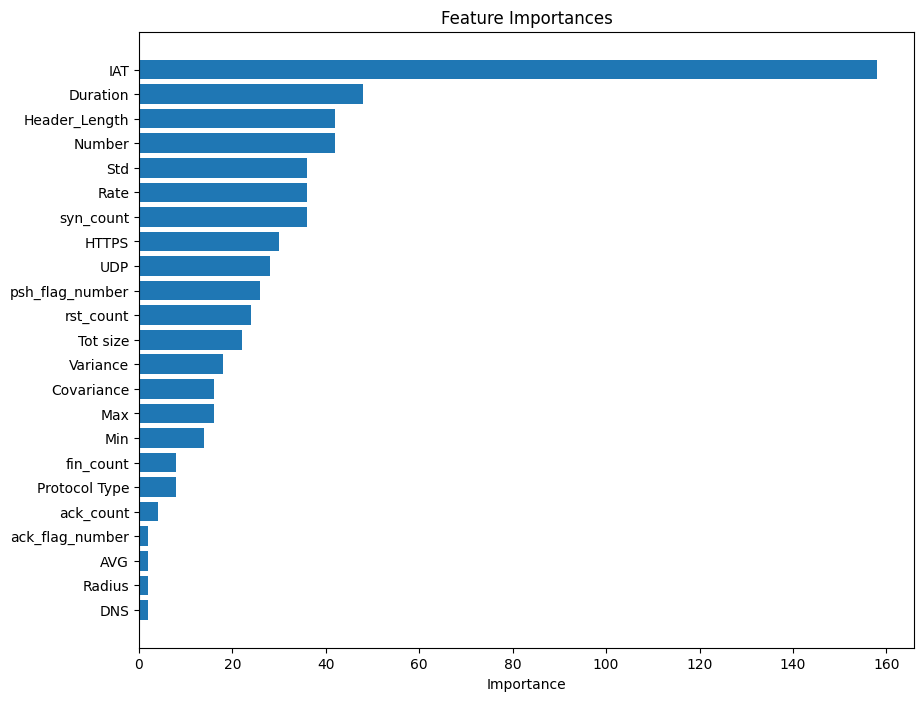

In [42]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = bst.get_score(importance_type='weight')

# Convert to DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': list(feature_importances.keys()),
    'Importance': list(feature_importances.values())
}).sort_values(by='Importance', ascending=True)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

Plotting summary for class 0


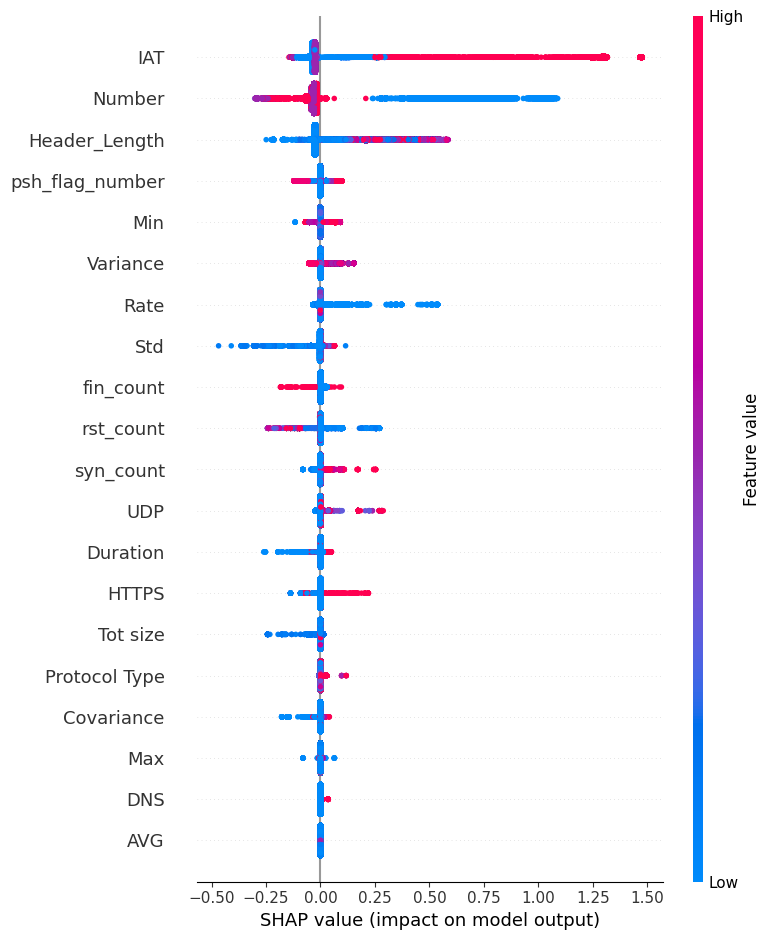

Plotting summary for class 1


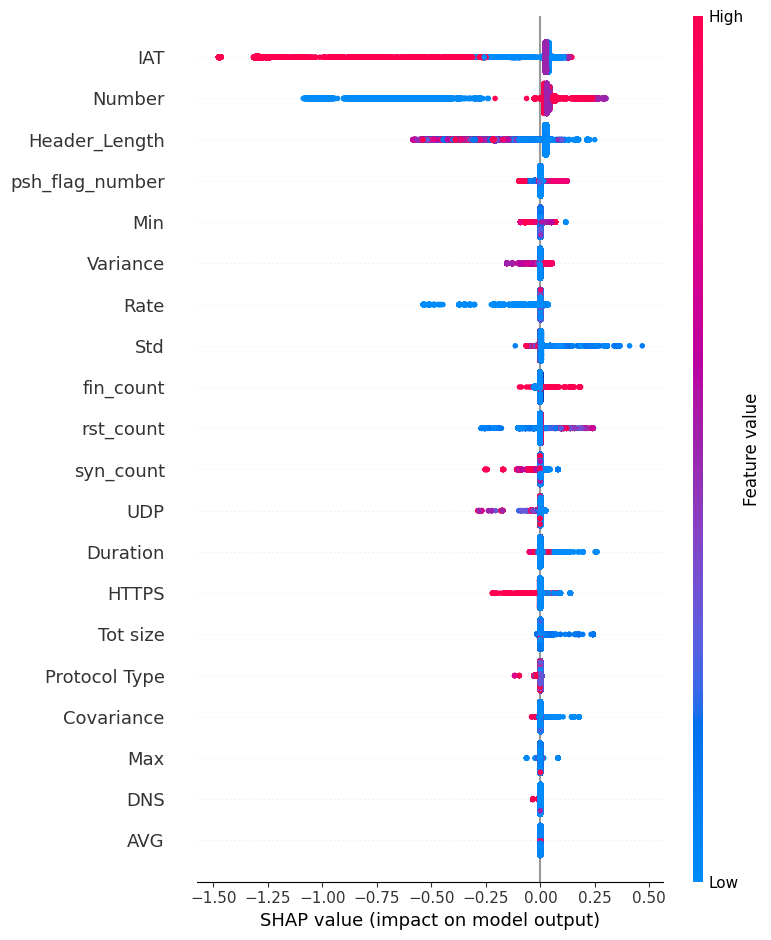

In [58]:
import shap

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(bst)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot for each class
num_classes = shap_values.shape[2]  # Number of classes

for class_index in range(num_classes):
    print(f"Plotting summary for class {class_index}")
    shap.summary_plot(shap_values[:, :, class_index], X_test)


Plotting dependence plot for class 0


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


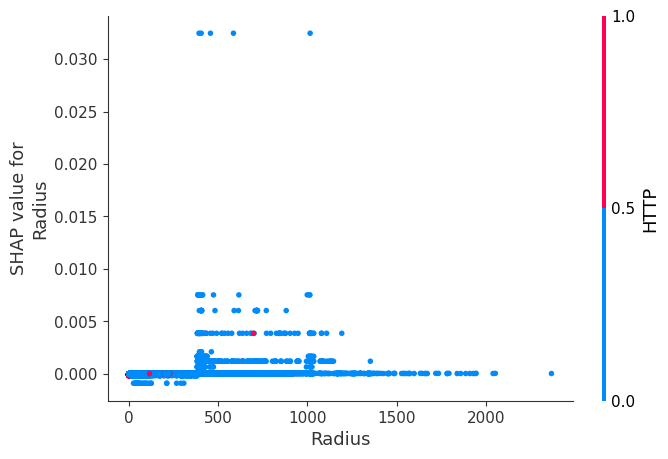

Plotting dependence plot for class 1


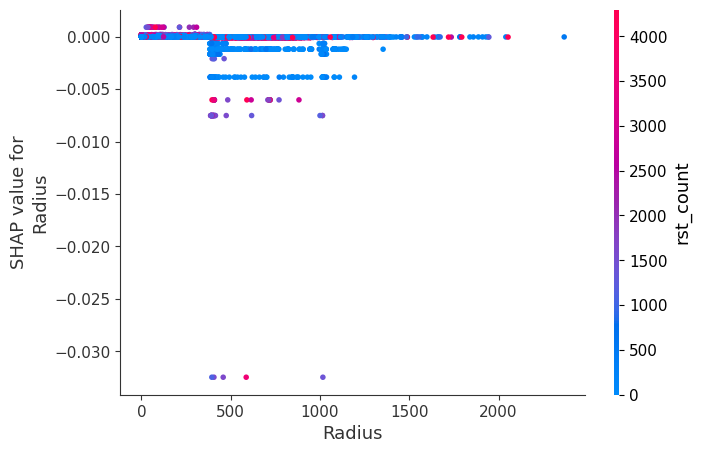

In [59]:
# Dependence plot for a specific feature for each class
feature_name = "Radius"
for class_index in range(num_classes):
    print(f"Plotting dependence plot for class {class_index}")
    shap.dependence_plot(feature_name, shap_values[:, :, class_index], X_test)


In [62]:
shap.initjs()
# Force plot for a specific instance and class
instance_index = 0  # Change as needed
class_index = 0     # Change as needed

shap.force_plot(
    explainer.expected_value[class_index],
    shap_values[instance_index, :, class_index],
    X_test.iloc[instance_index]
)